Library imports

In [1]:
import datetime
import pytz
import xml.etree.ElementTree as ET
import numpy as np
import pandas as pd
from dateutil import parser
import matplotlib.pyplot as plt
import time
import re
start_time = time.time()

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import bs4 as bs
import urllib.request
    
#%matplotlib inline

utc=pytz.UTC

#debug = True
debug = False

if debug == False:
    gpx_file = input('Enter file name (must be in same directory as this program for now): ')
    tree = ET.parse(gpx_file)
else:
    tree = ET.parse('ITPS_out.gpx')
    #tree = ET.parse('See_you_later_Winter_welcome_Spring.gpx')
root = tree.getroot()

each gps device has its own namespace for recording the GPX file... this function reads the embeded namespace

In [2]:
def namespace(element):
    m = re.match('\{(.*)\}', element.tag)
    return m.group(1) if m else ''

In [3]:
#url = 'http://vortex.plymouth.edu/cgi-bin/sfc/gen-statlog-a.cgi?ident=cyxu&pl=rawspec&yy=19&mm=04&dd=04&pg=web'
#dialog http://vortex.plymouth.edu/myo/sfc/statlog-a.html
#choose raw hourly & special METAR obs listings
#but only valid for us/cn/mx
#options
#http://www.ogimet.com/metars.phtml.en
#http://www.ogimet.com/display_metars2.php?lang=en&lugar=sbsp&tipo=ALL&ord=REV&nil=SI&fmt=html&ano=2019&mes=04&day=04&hora=00&anof=2019&mesf=04&dayf=04&horaf=23&minf=59&send=send

#https://www.cyclinganalytics.com/

In [4]:
#namespace = {'gpx':'http://www.topografix.com/GPX/1/1'}
namespace = {'gpx':namespace(root)}

In [5]:
#helper functions
def deg2rad(x):
    return x * np.pi / 180

def rad2deg(angle):
    return angle*180/np.pi

def kt2ms(speed):
    return speed * 0.5144444

def ms2kmh(speed):
    return speed * 3.6

This function calculates the distance and angle between 2 coordinates

In [6]:
def get_dist_trk(p2, p1):
    #p1 is a list with lat and long in degrees
    #p2 is also a list: lat long
    #returns distance and angle
    #reference: https://www.movable-type.co.uk/scripts/latlong.html
    R = 6371e3 #mean radius of Earth in meters
    phi1 = deg2rad(p1[0])
    phi2 = deg2rad(p2[0])
    lambda1 = deg2rad(p1[1])
    lambda2 = deg2rad(p2[1])
    delta_phi = phi2 - phi1
    delta_lambda = lambda2 - lambda1
    a = np.sin(delta_phi / 2) * np.sin(delta_phi / 2) + \
        np.cos(phi1) * np.cos(phi2) * \
        np.sin(delta_lambda / 2) * np.sin(delta_lambda / 2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = R * c
    y = np.sin(delta_lambda) * np.cos(phi2)
    x = np.cos(phi1) * np.sin(phi2) - \
        np.sin(phi1) * np.cos(phi2) * np.cos(delta_lambda)
    brg = np.arctan2(y,x) * 180 / np.pi
    return d, brg + 180

Loop through GPX file for each recorded track point and calculate distance and angle

In [7]:
print('Building track database...')
track = pd.DataFrame(columns=['lat', 'lon', 'elev', 'ts', 'dist', 'true_hdg', 'gs', 'delta_t', 'delta_elev'])
#lat in deg decimal
#lon in deg decimal
#elev in meters
#ts in datetime, tz=0
#dist in meters
#true_hdg in degrees
#gs in m/s
trackpoint = {}
debug_counter = 0
for trk in root.findall('gpx:trk', namespace):
    for trksegmt in trk.findall('gpx:trkseg', namespace):
        first_point = True
        trk_pts_number = len(trksegmt.findall('gpx:trkpt', namespace))
        ten_perc = int(len(trksegmt.findall('gpx:trkpt', namespace)) / 10)
        for idx, trkpoint in enumerate(trksegmt.findall('gpx:trkpt', namespace)):
            if (idx % ten_perc) == 0:
                print('{:0.0f}%... '.format(idx/trk_pts_number*100), end='')
            trackpoint['lat'] = float(trkpoint.get('lat'))
            trackpoint['lon'] = float(trkpoint.get('lon'))
            for elev in trkpoint.findall('gpx:ele', namespace):
                #print(elev.text)
                trackpoint['elev'] = float(elev.text)
            for ts in trkpoint.findall('gpx:time', namespace):
                #print(ts.text)
                trackpoint['ts'] = parser.parse(ts.text)
            if first_point:
                previous_point = trackpoint
                first_point = False
            dist, angle = get_dist_trk([previous_point['lat'],previous_point['lon']], [trackpoint['lat'],trackpoint['lon']])
            if debug_counter < 20:
                #print(dist, trackpoint['lon'], previous_point['lon'])
                debug_counter += 1
            
            trackpoint['delta_t'] = (trackpoint['ts']-previous_point['ts']).total_seconds()
            trackpoint['dist'] = dist
            trackpoint['true_hdg'] = angle
            if trackpoint['delta_t'] != 0:
                trackpoint['gs'] = dist / trackpoint['delta_t']
            else:
                trackpoint['gs'] = 0
                trackpoint['delta_t'] = np.nan
            trackpoint['delta_elev'] = (trackpoint['elev']-previous_point['elev'])
            previous_point = trackpoint
            track = track.append(trackpoint, ignore_index=True)
            trackpoint = {}
end_time = time.time()
print()
print('Track build time was {:1.1f} seconds'.format(end_time - start_time))

Building track database...
0%... 10%... 20%... 30%... 40%... 50%... 60%... 70%... 80%... 90%... 99%... 
Track build time was 12.2 seconds


In [8]:
print(track.head())

         lat        lon        elev                         ts       dist  \
0  43.029187 -81.159384  237.205681  2019-05-08 21:14:29+00:00   0.000000   
1  43.029099 -81.159693  237.063356  2019-05-08 21:14:31+00:00  26.877550   
2  43.029023 -81.159969  237.147467  2019-05-08 21:14:33+00:00  24.022621   
3  43.028942 -81.160254  237.245044  2019-05-08 21:14:35+00:00  24.855309   
4  43.028900 -81.160398  236.808639  2019-05-08 21:14:36+00:00  12.624379   

     true_hdg       gs  delta_t  delta_elev  
0  180.000000        0      NaN    0.000000  
1  248.778144  13.4388      2.0   -0.142325  
2  249.354003  12.0113      2.0    0.084110  
3  248.849919  12.4277      2.0    0.097577  
4  247.868276  12.6244      1.0   -0.436405  


In [9]:
#pandas
#shift
#apply
#applymap
#run apply on column and use lambda to filter the 2 data points and pass to function

Calculate the mean LAT / LON

Find weather stations near the mean

In [10]:
print('Figuring out nearest weather station...')
#nearest airport
#http://aviationweather.gov/adds/dataserver_current/httpparam?dataSource=stations&requestType=retrieve&format=xml&radialDistance=20;-81.275376,43.024538
lon_mean = track['lon'].mean()
lat_mean = track['lat'].mean()
ride_day = track['ts'][0].day
ride_month = track['ts'][0].month
ride_year = track['ts'][0].year

radial_distance = 20 #nm

url = 'http://aviationweather.gov/adds/dataserver_current/httpparam?dataSource=stations&requestType=retrieve' + \
      '&format=xml&radialDistance=' + str(radial_distance) + ';' + str(lon_mean) + ',' + str(lat_mean)

source = urllib.request.urlopen(url).read()
tree = ET.ElementTree(ET.fromstring(source))
root = tree.getroot()
station_id_list = []
for data in root.findall('data'):
    for station in data.findall('Station'):
        for station_ident in station.findall('station_id'):
            station_id_list.append(station_ident.text)
print('Nearest stations are: ', station_id_list)

Figuring out nearest weather station...
Nearest stations are:  ['CWSN', 'CYXU']


Cycle each station and try to find a METAR

If found, then create the weather database

If not found, asks user to enter prevailing wind speed and direction (true magnetic)

In [11]:
metar_found = False
station_index = 0
metar_db = []
while metar_found == False and station_index < len(station_id_list):
    #print(station_index)
    if station_id_list[station_index]!= '':
        url = 'http://www.ogimet.com/display_metars2.php?lang=en&lugar='+str(station_id_list[station_index])+ \
        '&tipo=ALL&ord=REV&nil=SI&fmt=html&ano='+str(ride_year)+ \
        '&mes='+str(ride_month)+'&day='+str(ride_day)+ \
        '&hora=00&anof='+str(ride_year)+'&mesf='+str(ride_month)+'&dayf='+str(ride_day)+ \
        '&horaf=23&minf=59&send=send'
        source = urllib.request.urlopen(url).read()
        soup = bs.BeautifulSoup(source, features='html.parser')
        table = soup.table
        table_rows = table.find_all('tr')
        metar_list = []
        for tr in table_rows:
            td = tr.find_all('td')
            row = [i.text for i in td]
            metar_list.append(row)
        for idx, line in enumerate(metar_list):
            #print(idx, line)
            for item in line:
                found = item.find('METAR '+str(station_id_list[station_index]))
                if found != -1:
                    metar_found = True
                    try:
                        mday = int(item[found+11:found+13])
                        mhour = int(item[found+13:found+15])
                        mminute = int(item[found+15:found+17])
                        wind_dir = int(item[found+19:found+22])
                        wind_spd = int(item[found+22:found+24])
                        metar_station = str(station_id_list[station_index])
                        #print('mday:', mday)
                        #print('mhour:', mhour)
                        #print('mminute:', mminute)
                        #print('wind_dir:', wind_dir)
                        #print('wind_spd:', wind_spd)
                        metar_db.append([wind_dir, wind_spd, datetime.datetime(year=ride_year, month=ride_month, day=ride_day, hour=0, minute=0, second=0, tzinfo=pytz.UTC)])
                    except:
                        #print('parsing error')
                        pass
        station_index += 1
if metar_found == False:
    print('no auto METAR data')
    wind_dir = input('Enter wind direction (true heading): ')
    wind_spd = input('Enter wind speed: ')
    metar_db.append([int(wind_dir), int(wind_spd), datetime.datetime(year=ride_year, month=ride_month, day=ride_day, hour=0, minute=0, second=0, tzinfo=pytz.UTC)])
else:
    print('Found METAR for ' + metar_station)

Found METAR for CYXU


Calculates the headwind component and stores in database

In [12]:
print('Calculating head winds...')
delta_angles = []
wind_component = []
for i in range(len(track)-1,-1, -1):
    lock_metar = False
    for j in range(len(metar_db)-1, -1, -1):
        if track['ts'].loc[i] >= metar_db[j][2] and not lock_metar:
            lock_metar = True
            #print(track['true_hdg'].loc[i], metar_db[j][0], track['true_hdg'].loc[i] - metar_db[j][0], track['ts'].loc[i], metar_db[j][2])
            delta_angles.insert(0,track['true_hdg'].loc[i] - metar_db[j][0])
            wind_component.insert(0,np.cos(deg2rad(track['true_hdg'].loc[i])) * kt2ms(metar_db[j][1]))

track['delta_ang'] = delta_angles
track['wind_component'] = wind_component
track['airspeed'] = track['gs'] + track['wind_component']
#delta_ang in degrees
#wind_component in m/s

Calculating head winds...


Calculates DRAG the power

Todo: interface for Cd and Area; Vary rho per altitude

In [13]:
print('Calculating power...')
rho = 1.225 #fixed for now kg/m3
Cd = 0.9 #fixed for me
S = 0.516 #measure from photo m2
track['drag'] = 0.5 * rho * track['airspeed']**2 * Cd * S
track['drag_work'] = track['drag'] * track['dist'] #J

Calculating power...


Calculates the potential energy work

Todo: interface for cyclist and bike mass

In [14]:
cyclist_mass = 80 #kg
bike_mass = 10 #kg

mass = cyclist_mass + bike_mass #kg
g = 9.8 #m/s2
track['pot_work'] = mass * g * track['delta_elev'] #J
track['total_work'] = track['drag_work'] + track['pot_work'] #J
track['power'] = track['total_work'] / (track['delta_t'].values)

In [15]:
print(track.describe())

              lat         lon        elev        dist    true_hdg     delta_t  \
count  774.000000  774.000000  774.000000  774.000000  774.000000  773.000000   
mean    43.026133  -81.228603  220.528919   16.256365  263.066335    2.209573   
std      0.003254    0.031537   13.210383   21.526026   54.687073    3.087676   
min     43.019511  -81.275760  204.146641    0.000000   12.351325    1.000000   
25%     43.023806  -81.256364  208.113434   12.124551  246.636417    2.000000   
50%     43.026442  -81.233251  218.045954   15.503276  250.198517    2.000000   
75%     43.028466  -81.202876  235.036937   18.462258  294.045406    2.000000   
max     43.032843  -81.159384  245.552213  497.665578  358.745422   68.000000   

       delta_elev   delta_ang  wind_component     pot_work  
count  774.000000  774.000000      774.000000   774.000000  
mean    -0.020711  -36.933665       -0.116936   -18.266790  
std      0.429091   54.687073        2.180795   378.458572  
min     -2.132303 -287.648

Calculate averages and basic comparisons...

In [16]:
total_work = track['total_work'].sum()
pos_power_filter = track['total_work'] >= 0
print('Total work was {:1.0f} Joules'.format(total_work))
workout_time = track['ts'].iloc[-1]-track['ts'].iloc[0]
print('Workout time was {}, or {:1.0f} seconds'.format(workout_time, workout_time.total_seconds()))
print('Average overall power was {:1.0f} Watts'.format(total_work / workout_time.total_seconds()))
print('Average positive power was {:1.0f} Watts'.format(track[track['total_work'] >= 0]['total_work'].sum() / workout_time.total_seconds()))

Total work was 244261 Joules
Workout time was 0 days 00:28:28, or 1708 seconds
Average overall power was 143 Watts
Average positive power was 169 Watts


In [17]:
end_time = time.time()
print('execution time was {:0.1f} seconds'.format(end_time - start_time))

execution time was 18.9 seconds


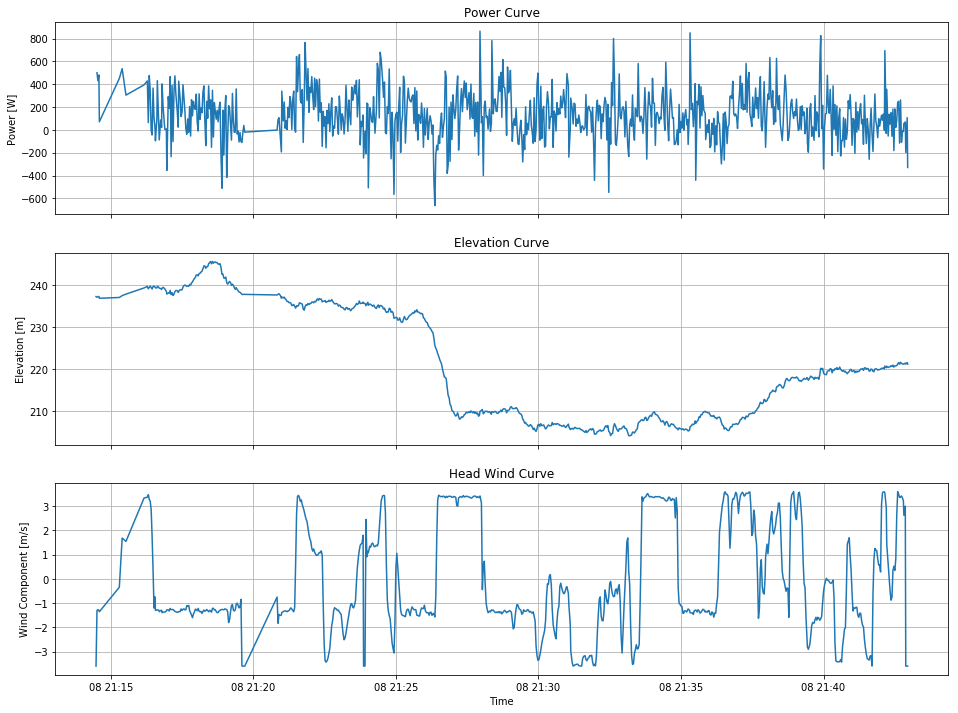

In [18]:
plt.rcParams['figure.figsize'] = [16, 12]
f, axarr = plt.subplots(3, sharex=True)
axarr[0].plot((track['ts']),track['power'])

axarr[0].set(ylabel='Power [W]',
       title='Power Curve')
axarr[0].grid()

axarr[1].plot((track['ts']),track['elev'])

axarr[1].set(ylabel='Elevation [m]',
       title='Elevation Curve')
axarr[1].grid()

axarr[2].plot((track['ts']),track['wind_component'])

axarr[2].set(xlabel='Time', ylabel='Wind Component [m/s]',
       title='Head Wind Curve')
axarr[2].grid()
             

#fig.savefig("test.png")
plt.show()


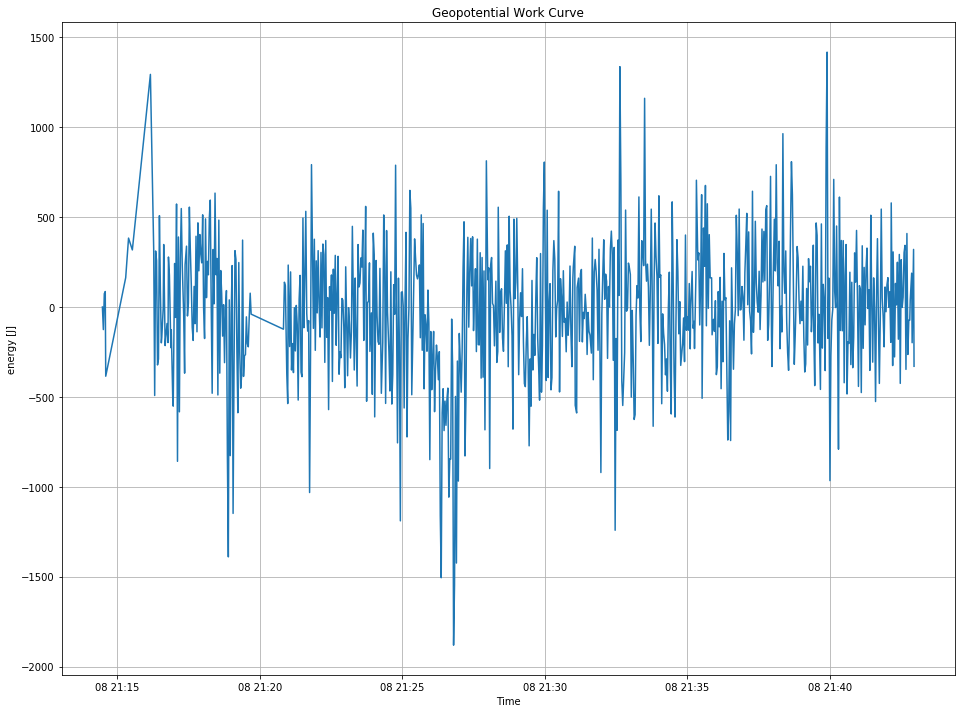

In [19]:
fig, ax = plt.subplots()
ax.plot((track['ts']),track['pot_work'])

ax.set(xlabel='Time', ylabel='energy [J]',
       title='Geopotential Work Curve')
ax.grid()

#fig.savefig("test.png")
plt.show()

In [ ]:
'''
f, axarr = plt.subplots(4, sharex=True)
axarr[0].plot((track['ts']),track['power'], alpha=0.8, linewidth=0.3)

axarr[0].set(xlabel='Time', ylabel='Power [W]',
       title='Power Curve')
axarr[0].set_ylim([0, track['power'].max()])
axarr[0].grid()

axarr[1].plot((track['ts']),track['elev'])

axarr[1].set(xlabel='Time', ylabel='Elevation [m]',
       title='Elevation Curve')
axarr[1].grid()

axarr[2].plot((track['ts']),track['delta_ang'])

axarr[2].set(xlabel='Time', ylabel='delta [deg]',
       title='Wind Relative Angle Curve')
axarr[2].grid()

axarr[3].plot((track['ts']),track['delta_elev'])

axarr[3].set(xlabel='Time', ylabel='[m]',
       title='Delta Elev')
axarr[3].grid()
             

#fig.savefig("test.png")
plt.show()
'''

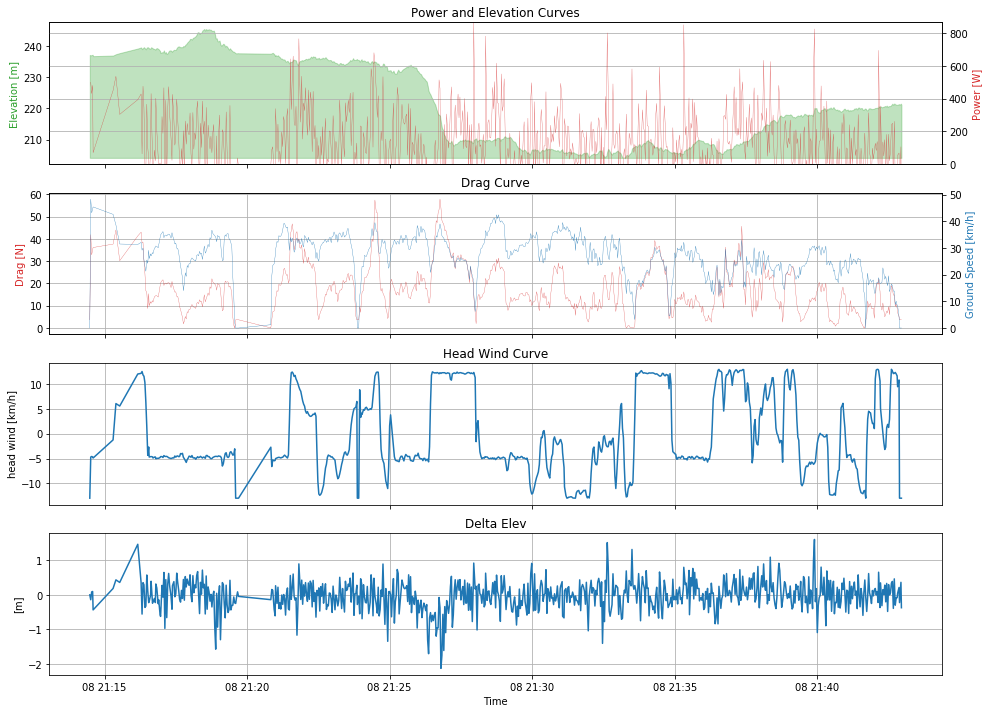

In [20]:
f, axarr = plt.subplots(4, sharex=True)

color = 'tab:green'
axarr[0].fill_between((track['ts']),track['elev'].min(),track['elev'], color=color, alpha=0.3)
axarr[0].set_ylabel('Elevation [m]', color=color)
#fill_between(x, 0, y1)

color = 'tab:red'
ax2 = axarr[0].twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot((track['ts']),track['power'], alpha=0.8, linewidth=0.3, color=color)

ax2.set(xlabel='Time', title='Power and Elevation Curves')
ax2.set_ylabel('Power [W]', color=color)
ax2.set_ylim([0, track['power'].max()])
ax2.grid()

color = 'tab:red'
axarr[1].plot((track['ts']),track['drag'], alpha=0.8, linewidth=0.3, color=color)


axarr[1].set(title='Drag Curve')
axarr[1].set_ylabel(ylabel='Drag [N]', color=color)
axarr[1].grid()

color = 'tab:blue'
gs_kmh = ms2kmh(track['gs'])
ax3 = axarr[1].twinx()  # instantiate a second axes that shares the same x-axis
ax3.plot((track['ts']), gs_kmh, color=color, linewidth=0.3)
ax3.set_ylabel('Ground Speed [km/h]', color=color)

axarr[2].plot((track['ts']),ms2kmh(track['wind_component']))

axarr[2].set(ylabel='head wind [km/h]',
       title='Head Wind Curve')
axarr[2].grid()

axarr[3].plot((track['ts']),track['delta_elev'])

axarr[3].set(xlabel='Time', ylabel='[m]',
       title='Delta Elev')
axarr[3].grid()
             

#fig.savefig("test.png")
plt.show()

Power Histogram

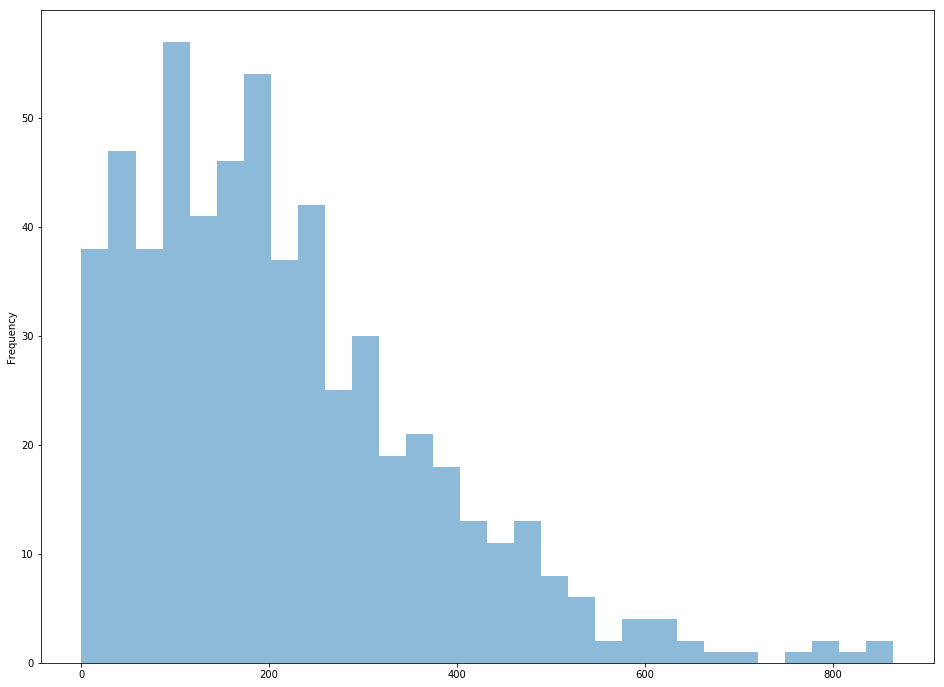

In [21]:
track[track['total_work'] >= 0]
ax = track[track['power']>=0]['power'].plot.hist(bins=30, alpha=0.5)

Power Bins/Time

Let's plot now how many minutes was spent in each power bin.

Change the power range and bin size below.

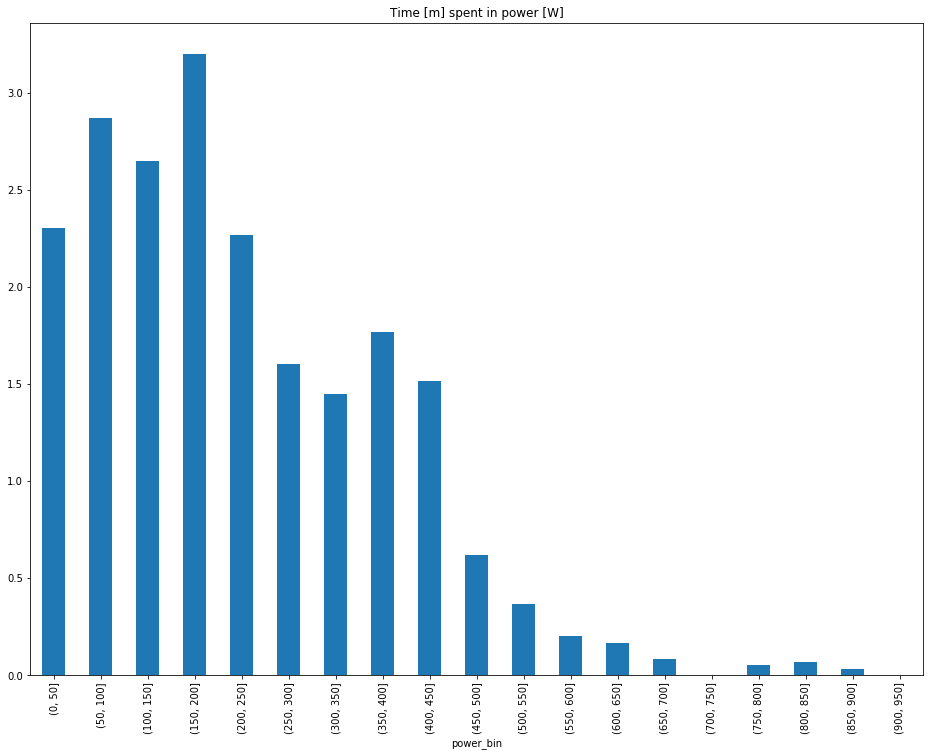

In [22]:
min_power = 0
max_power = 1000
power_bin_width = 50


power_bins =  range(min_power, max_power, power_bin_width)
track['power_bin'] = pd.cut(track['power'], power_bins)
((track.groupby(['power_bin']).sum().loc[:,'delta_t'])/60).plot(kind='bar', title='Time [m] spent in power [W]');

In [23]:
track.head(15)

,lat,lon,elev,ts,dist,true_hdg,gs,delta_t,delta_elev,delta_ang,wind_component,airspeed,drag,drag_work,pot_work,total_work,power,power_bin
0,43.029187,-81.159384,237.205681,2019-05-08 21:14:29+00:00,0.000000,180.000000,0,NaN,0.000000,-120.000000,-3.601111,-3.60111,3.68868,0,0.000000,0,NaN,NaN
1,43.029099,-81.159693,237.063356,2019-05-08 21:14:31+00:00,26.877550,248.778144,13.4388,2.0,-0.142325,-51.221856,-1.303531,12.1352,41.8886,1125.86,-125.530759,1000.33,500.165,"(0.0, 50.0]"
2,43.029023,-81.159969,237.147467,2019-05-08 21:14:33+00:00,24.022621,249.354003,12.0113,2.0,0.084110,-50.645997,-1.269726,10.7416,32.8197,788.416,74.185364,862.601,431.301,"(50.0, 100.0]"
3,43.028942,-81.160254,237.245044,2019-05-08 21:14:35+00:00,24.855309,248.849919,12.4277,2.0,0.097577,-51.150081,-1.299325,11.1283,35.2256,875.543,86.063086,961.606,480.803,"(450.0, 500.0]"
4,43.028900,-81.160398,236.808639,2019-05-08 21:14:36+00:00,12.624379,247.868276,12.6244,1.0,-0.436405,-52.131724,-1.356672,11.2677,36.1135,455.91,-384.909203,71.0011,71.0011,"(50.0, 100.0]"
5,43.028469,-81.166492,236.993541,2019-05-08 21:15:18+00:00,497.665578,264.480964,11.8492,42.0,0.184902,-35.519036,-0.346342,11.5028,37.6364,18730.4,163.083705,18893.4,449.844,"(400.0, 450.0]"
6,43.028740,-81.167193,237.428185,2019-05-08 21:15:24+00:00,64.469060,297.883454,10.7448,6.0,0.434644,-2.116546,1.684148,12.429,43.941,2832.84,383.355857,3216.19,536.032,"(500.0, 550.0]"
7,43.029011,-81.167972,237.788261,2019-05-08 21:15:32+00:00,70.059030,295.442647,8.75738,8.0,0.360076,-4.557353,1.547064,10.3044,30.2028,2115.98,317.587247,2433.57,304.196,"(300.0, 350.0]"
8,43.031769,-81.169506,239.255214,2019-05-08 21:16:10+00:00,331.057783,337.864019,8.71205,38.0,1.466953,37.864019,3.335681,12.0477,41.2865,13668.2,1293.852733,14962.1,393.739,"(350.0, 400.0]"
9,43.032295,-81.169776,239.609345,2019-05-08 21:16:17+00:00,62.470308,339.433669,8.92433,7.0,0.354130,39.433669,3.371598,12.2959,43.0052,2686.55,312.343043,2998.89,428.413,"(400.0, 450.0]"
